<a href="https://colab.research.google.com/github/tohyongyao/AI-Project/blob/master/TYY_TF2_Lyrics_Word_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Song Lyrics Generator

The objective of this project is to generate Taylor Swift song lyrics through the use of RNN.

Dataset: https://www.kaggle.com/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums



In [0]:
%tensorflow_version 2.x

In [1]:
# Testing for GPU

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!nvidia-smi

Tue Apr 14 07:11:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    35W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Bootstrapping

Import colab_helper

Cloning into 'colab_helper'...
remote: Enumerating objects: 277, done.
remote: Total 277 (delta 0), reused 0 (delta 0), pack-reused 277
Receiving objects: 100% (277/277), 56.17 KiB | 2.96 MiB/s, done.
Resolving deltas: 100% (170/170), done.


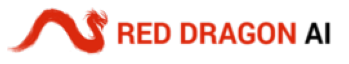

In [3]:
! git clone https://github.com/mdda/colab_helper
from colab_helper import utils as chu

Mount Google Drive

In [4]:
chu.gdrive_mount(point='gdrive', link='my_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive
'gdrive/My Drive' mounted as 'my_drive'


Login to Kaggle

In [5]:
! pip install kaggle
chu.kaggle_credentials(file='./my_drive/Colab Notebooks/kaggle.json')

Credentials written to /root/.kaggle/kaggle.json


Download Dataset from Kaggle

In [6]:
! kaggle datasets download -d PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums

  0% 0.00/68.7k [00:00<?, ?B/s]
100% 68.7k/68.7k [00:00<00:00, 27.2MB/s]


In [7]:
!unzip taylor-swift-song-lyrics-from-all-the-albums.zip

Archive:  taylor-swift-song-lyrics-from-all-the-albums.zip
  inflating: taylor_swift_lyrics.csv  


## Imports

In [10]:
pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [12]:
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from keras.utils.data_utils import get_file

import tensorflow as tf
import numpy as np
import random
import sys
import pandas as pd

Using TensorFlow backend.


In [9]:
print(tf.keras.__version__)
print(tf.__version__)

2.3.0-tf
2.2.0-rc2


## Load Dataset

In [0]:
dataset = pd.read_csv('taylor_swift_lyrics.csv',encoding = "latin1")

# Preprocess the lyrics

In [14]:
# Get all lyrics
lyrics = dataset['lyric'].tolist() 

# combine and convert to lower case
lyrics_text = ''
for i in lyrics: 
  lyrics_text += i.lower() + ' ' 

print('Lyrics length:', len(lyrics_text))
print(lyrics_text[:50])

Lyrics length: 173604
he said the way my blue eyes shined put those geor


In [15]:
chars = sorted(list(set(lyrics_text)))

# make look up tables
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('Number of unique chars:', len(chars))
print(chars)

Number of unique chars: 57
[' ', '!', '"', '&', "'", '(', ')', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '7', '8', '9', ':', ';', '<', '>', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x85', '\x91', '\x93', '\x94', '\x96', '\x97']


In [16]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 100
step = 3

lyrics_lines = []
next_chars = []

for i in range(0, len(lyrics_text) - maxlen, step):
    lyrics_lines.append(lyrics_text[i: i + maxlen])
    next_chars.append(lyrics_text[i + maxlen])
print('nb sequences:', len(lyrics_lines))

nb sequences: 57835


In [0]:
# vectorizing the sentences: characters in One Hot Encode (OHE) out
x = np.zeros((len(lyrics_lines), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(lyrics_lines), len(chars)), dtype=np.bool)
for i, lyrics_line in enumerate(lyrics_lines):
    for t, char in enumerate(lyrics_line):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [22]:
x.shape

(57835, 100, 57)

In [19]:
x[0,0,:]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Building the model


In [0]:
# build the model: 2 LSTM layers
model = Sequential()
num_nodes = 128
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid', input_shape=(maxlen, len(chars)), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(len(chars))) # output layer
model.add(Activation('softmax'))

In [0]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer) # loss and optimizer

In [36]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 128)          95232     
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 57)                7353      
_________________________________________________________________
activation_2 (Activation)    (None, 57)                0         
Total params: 234,169
Trainable params: 234,169
Non-trainable params: 0
_________________________________________________________________


## Sampling some text from the model

Reused helper functions from the Char RNN example.

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    if epoch % 10 > 0:
      return
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(lyrics_text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = lyrics_text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

## Callback functions

In [0]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# This callback will help to save the weights based on the minimum loss
checkpoint_name = 'Weights-TSLG-{epoch:02d}-{loss:0.3f}.hdf5'
checkpoint_callback = ModelCheckpoint(checkpoint_name, monitor='loss', verbose=0, save_best_only=True, mode='min')

## Train the model

In [53]:
model.fit(x, y,
          batch_size=128,
          epochs=10, #adjust the epochs as necessary
          callbacks=[print_callback, checkpoint_callback])

Epoch 1/10
451/452 [============================>.] - ETA: 0s - loss: 0.2689
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " high was worth the pain got a long list of ex-lovers they'll tell you i'm insane 'cause you know i "
 high was worth the pain got a long list of ex-lovers they'll tell you i'm insane 'cause you know i love if

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


 it goes you don't know how it goes (starlight like we're made of stand and i know places lovecs in alone and i'll be with you said 'cause i'd gate 'ss, you are is mange on hall you talk me around when we donckess i don't know how it goes (starts i could but no one things? like right you ve stay when the nathing that we said hello and your eyes look like mad deep the phone this is the last 
----- diversity: 0.5
----- Generating with seed: " high was worth the pain got a long list of ex-lovers they'll tell you i'm insane 'cause you know i "
 high was worth the pain got a long list of ex-lovers they'll tell you i'm insane 'cause you know i love if it doesn't want you like room to new york ween i'm burneling of your feelight i never know you so it all to tell me my frou know you are in love when you said you're fifteen and your wildfee through all alone for it? but i'm the one who unders try something my heap) and when you make the last time i'm asking you whise too what you'll know that 

Save and load weights as necessary

In [0]:
model.save_weights('weights.hdf5')

In [0]:
model.load_weights('weights.hdf5')

## Have fun with the generator!

In [0]:
def generate_lyrics():
  start_index = random.randint(0, len(lyrics_text) - maxlen - 1)
  for diversity in [0.2, 0.5, 1.0, 1.2]:
      print('----- diversity:', diversity)

      generated = ''
      sentence = lyrics_text[start_index: start_index + maxlen]
      generated += sentence
      print('----- Generating with seed: "' + sentence + '"')
      sys.stdout.write(generated)

      for i in range(400):
          x_pred = np.zeros((1, maxlen, len(chars)))
          for t, char in enumerate(sentence):
              x_pred[0, t, char_indices[char]] = 1.

          preds = model.predict(x_pred, verbose=0)[0]
          next_index = sample(preds, diversity)
          next_char = indices_char[next_index]

          generated += next_char
          sentence = sentence[1:] + next_char

          sys.stdout.write(next_char)
          sys.stdout.flush()
      print()

In [54]:
generate_lyrics()

----- diversity: 0.2
----- Generating with seed: "n't rush into things? didn't you flash your green eyes at me? haven't you heard what becomes of curi"
n't rush into things? didn't you flash your green eyes at me? haven't you heard what becomes of curirs lips ju

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


st this ahls i can't help me in your dad dreams say you'll see me again dreams say you'll see me again dreams say you'll remembered everything in the sides like a drives away now i'm love out of everything has changed the floor afyorrying the lick about tle to me but so mack of anytell oh, who you and the careful friends dark in my realook on how that i said all that? is it too soon to t
----- diversity: 0.5
----- Generating with seed: "n't rush into things? didn't you flash your green eyes at me? haven't you heard what becomes of curi"
n't rush into things? didn't you flash your green eyes at me? haven't you heard what becomes of curirs lips just through the srees liht miss forever and ever (and i said rookd and he's the best thing she's pict perfect, been the sides are jeden thein little dancing to let it got a little shame on me how i could be a resalight andtelo you think that it's slace together will to hold on the ground i was ffeeling to fit in a mine anent gone things that they

## Conclusion

The generator would occasionally churn out phrases that look like song lyrics but does not perform as well as expected. Many spelling errors and incoherent punctuations. 